In [1]:
%load_ext autoreload
%autoreload 2

from ocean_navigation_simulator.generative_error_model.generative_model_metrics import rmse_over_time_xr, rmse_over_time, vector_correlation_over_time_xr, vector_correlation
import os
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd

## Compute Synthetic RMSE

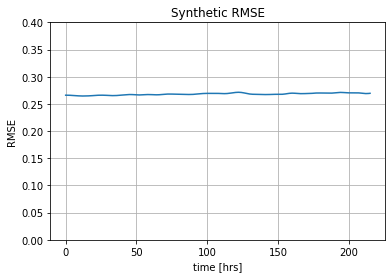

In [44]:
error_data_root = "/home/jonas/Documents/Thesis/OceanPlatformControl/data/drifter_data/synthetic_error/area1"
files = os.listdir(error_data_root)
rmse = []
for file in files:
    data = xr.open_dataset(os.path.join(error_data_root, file))
    rmse.append(rmse_over_time_xr(data))
rmse = np.array(rmse).mean(axis=0)

plt.plot(range(len(rmse)), rmse)
plt.ylim([0, 0.4])
plt.title("Synthetic RMSE")
plt.ylabel("RMSE")
plt.xlabel("time [hrs]")
plt.grid()

## Compute Empirical RMSE

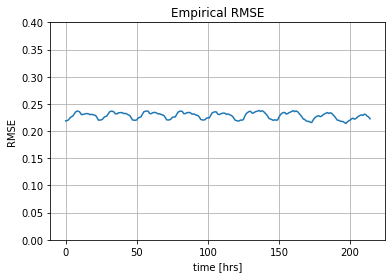

In [45]:
error_data_root = "/home/jonas/Documents/Thesis/OceanPlatformControl/data/drifter_data/dataset_forecast_error/area1"
files = sorted(os.listdir(error_data_root))
rmse_data = []
for file in files[:50]:
    data = pd.read_csv(os.path.join(error_data_root, file))
    rmse_data.append(rmse_over_time(data)["rmse"])
# take average for each hour
rmse_data = np.array(rmse_data).mean(axis=0)

plt.plot(range(len(rmse_data)), rmse_data)
plt.ylim([0, 0.4])
plt.title("Empirical RMSE")
plt.ylabel("RMSE")
plt.xlabel("time [hrs]")
plt.grid()

## Compute Synthetic Vector Correlation

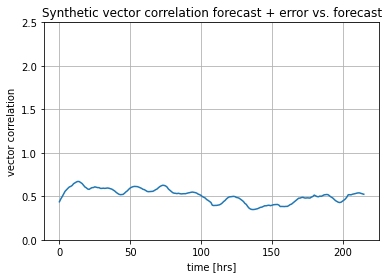

In [47]:
# forecast + synth error vs forecast

error_data_root = "/home/jonas/Documents/Thesis/OceanPlatformControl/data/drifter_data/synthetic_error/area1"
error_files = sorted(os.listdir(error_data_root))

forecast_root = "/home/jonas/Documents/Thesis/OceanPlatformControl/data/drifter_data/forecasts/area1"
forecast_files = sorted(os.listdir(forecast_root))[:len(error_files)]

vec_corr = []
for error_file, forecast_file in zip(error_files, forecast_files):
    error_data = xr.open_dataset(os.path.join(error_data_root, error_file))
    forecast_data = xr.open_dataset(os.path.join(forecast_root, forecast_file))
    vec_corr.append(vector_correlation_over_time_xr(error_data, forecast_data))
    break
vec_corr = np.array(vec_corr).mean(axis=0)

plt.plot(range(len(vec_corr)), vec_corr)
plt.ylim([0, 2.5])
plt.title("Synthetic vector correlation forecast + error vs. forecast")
plt.xlabel("time [hrs]")
plt.ylabel("vector correlation")
plt.grid()

## Compute Empirical Vector Correlation

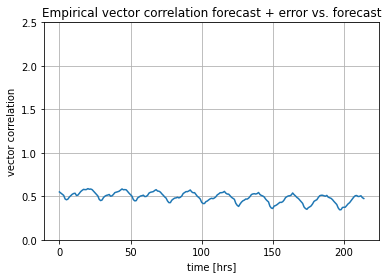

In [46]:
# use forecast error + forecast or alternatively buoy data directly
# use forecast+error vs forecast
from ocean_navigation_simulator.generative_error_model.Dataset import Dataset

forecast_error_root = "/home/jonas/Documents/Thesis/OceanPlatformControl/data/drifter_data/dataset_forecast_error/area1"
error_files = sorted(os.listdir(forecast_error_root))[:50]
vec_corr_tot = []
for file in error_files:
    data = pd.read_csv(os.path.join(forecast_error_root, file))
    data["hour"] = data["time"].apply(lambda x: x[:13])
    hours = sorted(set(data["hour"].tolist()))
    vec_corr = []
    for hour in hours:
        u_forecast_and_error = data[data["hour"] == hour]["u"]
        v_forecast_and_error = data[data["hour"] == hour]["v"]
        u_forecast = data[data["hour"] == hour]["u_forecast"]
        v_forecast = data[data["hour"] == hour]["v_forecast"]
        # append vec corr for each hour for each file
        vec_corr.append(vector_correlation(u_forecast_and_error, v_forecast_and_error, u_forecast, v_forecast))
    vec_corr_tot.append(np.array(vec_corr))
vec_corr = np.array(vec_corr_tot).mean(axis=0)

plt.plot(range(len(vec_corr)), vec_corr)
plt.ylim([0, 2.5])
plt.title("Empirical vector correlation forecast + error vs. forecast")
plt.xlabel("time [hrs]")
plt.ylabel("vector correlation")
plt.grid()

## Compute stats of opensimplex

In [34]:
import opensimplex
import numpy as np

simplex_gen = opensimplex.OpenSimplex(seed=12345678)
num_pts = int(2e2)
num_of_loops = 100
means = []
sum = 0
sumsq = 0
for i in range(num_of_loops):
    rand_x = np.random.uniform(0, 1000, num_pts)
    rand_y = np.random.uniform(0, 1000, num_pts)
    rand_z = np.random.uniform(0, 1000, num_pts)
    rand_t = np.random.uniform(0, 1000, num_pts)
    samples = np.array(simplex_gen.noise3array(rand_x, rand_y, rand_z))
    means.append(samples.mean())
    sum += samples.sum()
    sumsq += np.square(samples).sum()

print(np.array(means).mean())
print((sumsq - (sum * sum)/(num_of_loops*num_pts**3))/(num_of_loops*num_pts**3))

-7.076037679000259e-06
0.09792579099296904


## Generate synthetic test data

In [47]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt

from ocean_navigation_simulator.generative_error_model.variogram.Variogram import Variogram
from ocean_navigation_simulator.generative_error_model.variogram.VisualizeVariogram import VisualizeVariogram

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [77]:
# generate similar data nearby
start_time = datetime.datetime(2022, 4, 21)
lon_close = np.random.choice(list(np.arange(0, 2, 0.01)), 1000)
lat_close = np.random.choice(list(np.arange(0, 2, 0.01)), 1000)
hours = list(np.random.choice(list(np.arange(0, 24, 1)), 1000))
time_close = np.array([start_time + datetime.timedelta(hours=int(hour)) for hour in hours])
u_error_close = np.random.normal(0, 0.1, size=time_close.shape)

close_data = pd.DataFrame({"lon": lon_close,
                           "lat": lat_close,
                           "time": time_close,
                           "u_error": u_error_close,
                           "v_error": u_error_close})

# generate different data at larger distance
lon = np.random.choice(list(np.arange(0, 10, 0.01)), 30000)
lat = np.random.choice(list(np.arange(0, 10, 0.01)), 30000)
hours = np.random.choice(list(np.arange(0, 24*9, 1)), 30000)
time = np.array([start_time + datetime.timedelta(hours=int(hour)) for hour in hours])
u_error = np.random.normal(0, 4, size=time.shape)

far_data = pd.DataFrame({"lon": lon,
                         "lat": lat,
                         "time": time,
                         "u_error": u_error,
                         "v_error": u_error})

# filter out data in closest cube
far_data = far_data[(far_data["lon"] > 2) | (far_data["lat"] > 2) | (far_data["time"] >= '2022-04-22')]
print(far_data.describe())

data = pd.concat([close_data, far_data], ignore_index=True)
data.to_csv("~/Downloads/temp.csv", index_label=False)

                lon           lat       u_error       v_error
count  29873.000000  29873.000000  29873.000000  29873.000000
mean       5.018162      5.005696     -0.019985     -0.019985
std        2.878891      2.883193      3.981716      3.981716
min        0.000000      0.000000    -15.325365    -15.325365
25%        2.550000      2.510000     -2.701037     -2.701037
50%        5.000000      5.000000     -0.034724     -0.034724
75%        7.520000      7.500000      2.682288      2.682288
max        9.990000      9.990000     16.720847     16.720847


In [78]:
data = pd.read_csv("~/Downloads/temp.csv")
data

,lon,lat,time,u_error,v_error
0,0.61,1.59,2022-04-21 16:00:00,0.022627,0.022627
1,0.73,1.34,2022-04-21 23:00:00,-0.155595,-0.155595
2,0.57,1.49,2022-04-21 15:00:00,0.105529,0.105529
3,1.38,0.64,2022-04-21 08:00:00,-0.016341,-0.016341
4,1.96,1.90,2022-04-21 07:00:00,-0.102072,-0.102072
...,...,...,...,...,...
30868,1.52,8.14,2022-04-22 06:00:00,6.452988,6.452988
30869,7.63,2.48,2022-04-24 12:00:00,4.637260,4.637260
30870,1.71,0.04,2022-04-29 02:00:00,6.569057,6.569057
30871,3.72,0.78,2022-04-22 10:00:00,0.514863,0.514863


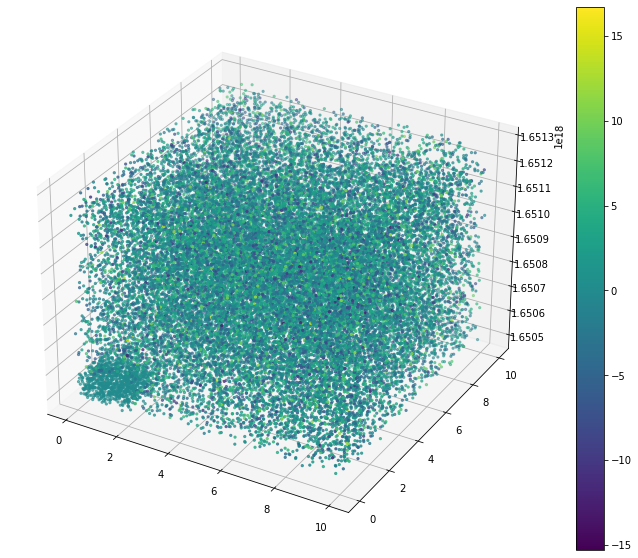

In [81]:
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(projection="3d")
plot = ax.scatter(data["lon"], data["lat"], data["time"], c=data["u_error"], marker=".")
plt.colorbar(plot, ax=ax)

In [79]:
v = Variogram(data)
v.detrend()
bins, bins_count = v.build_variogram_gen((5, 1), num_workers=2, chunk_size=int(1e6), cross_buoy_pairs_only=False, is_3d=False)
vvis = VisualizeVariogram(None, variogram=v)
bins.shape

(315, 216, 2)

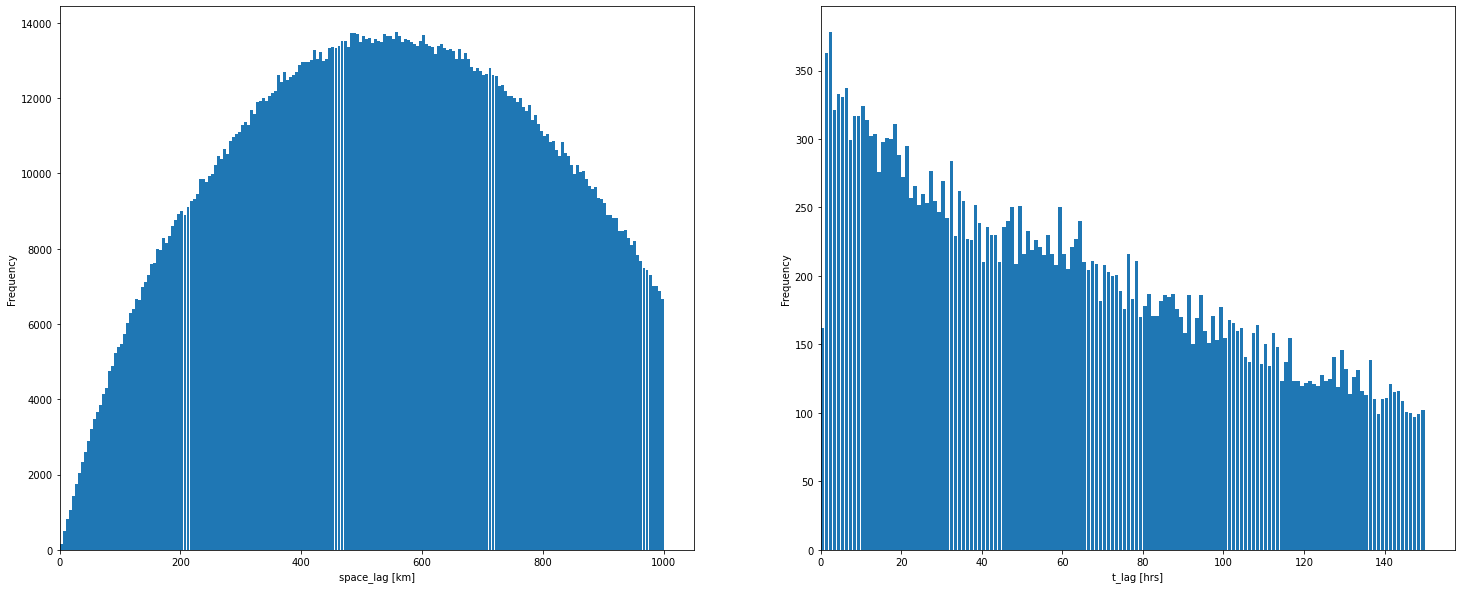

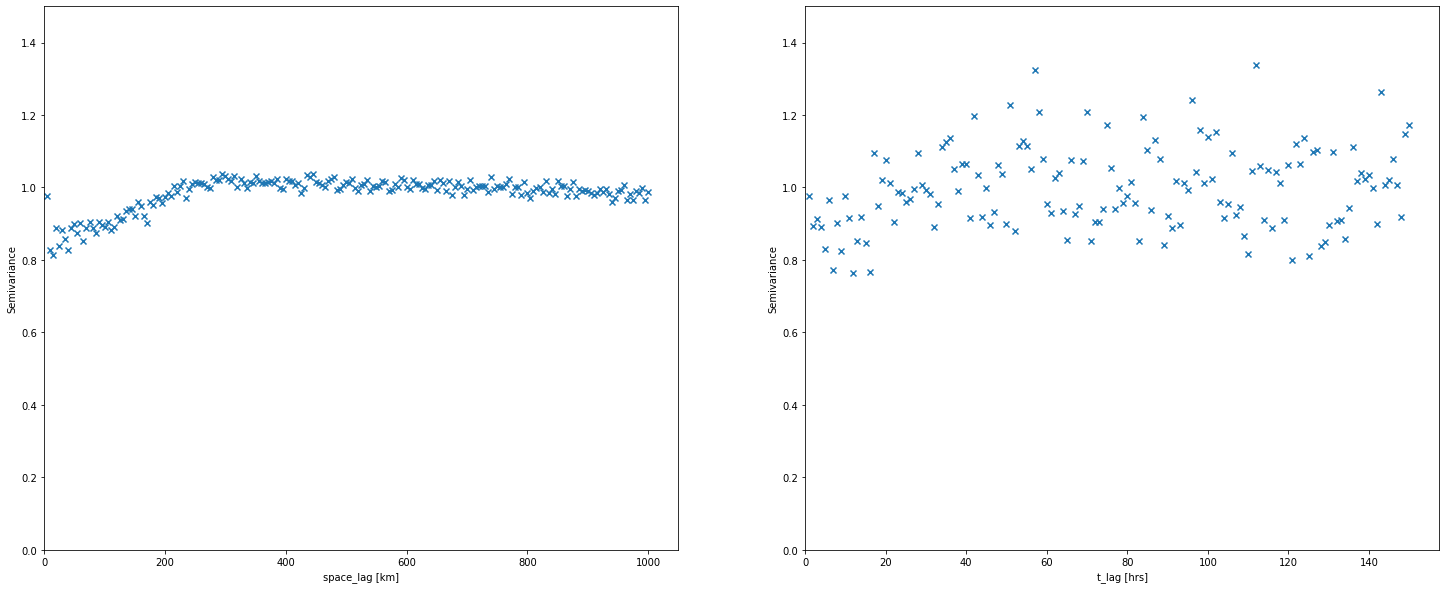

In [86]:
vvis.decrease_variogram_res((5, 1))
view_range = [1000, 150]
vvis.plot_histograms(view_range=view_range)
vvis.plot_variograms(view_range=view_range)

## Visualizing Simplex Noise Sample with Buoy Points

copernicus_forecast_error_lon_[-140, -120]_lat_[20.0, 30.0]_time_2022-04-21T18:30:00Z__2022-04-30T17:30:00Z.csv
synthetic_data_error_lon_[-140,-120]_lat_[20,30]_time_2022-04-21T12:30:00Z__2022-04-30T12:30:00Z.csv
synthetic_data_error_lon_[-140,-120]_lat_[20,30]_time_2022-04-21T12:30:00Z__2022-04-30T12:30:00Z.nc


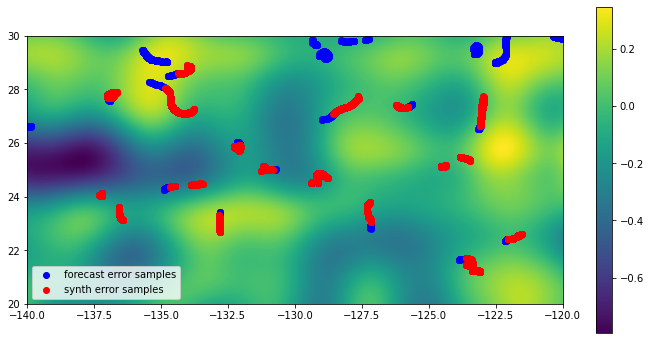

In [26]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np

fig = plt.figure(figsize=(12,6))

fc_error_dir = "/home/jonas/Documents/Thesis/OceanPlatformControl/data/drifter_data/dataset_forecast_error/area1"
fc_files = sorted(os.listdir(fc_error_dir))
print(fc_files[0])
data_fc_error = pd.read_csv(os.path.join(fc_error_dir, fc_files[0]))
plt.scatter(data_fc_error["lon"], data_fc_error["lat"], color="b", label="forecast error samples")

synth_data_dir = "/home/jonas/Documents/Thesis/OceanPlatformControl/data/drifter_data/dataset_synthetic_error/area1"
files = sorted(os.listdir(synth_data_dir))
print(files[0])
data = pd.read_csv(os.path.join(synth_data_dir, files[0]))

plt.scatter(data["lon"], data["lat"], color="r", label="synth error samples")
plt.xlim([-140, -120])
plt.ylim([20, 30])

error_dir = "/home/jonas/Documents/Thesis/OceanPlatformControl/data/drifter_data/synthetic_error/area1"
error_files = sorted(os.listdir(error_dir))
print(error_files[0])
data_full_error = xr.open_dataset(os.path.join(error_dir, error_files[0]))
# fig2 = plt.figure()
xlimits = [data_full_error["lon"].min(), np.round(data_full_error["lon"].max())]
ylimits = [data_full_error["lat"].min(), np.round(data_full_error["lat"].max())]
plt.imshow(data_full_error["u_error"].values[0, :, :], extent=[xlimits[0], xlimits[1], ylimits[0], ylimits[1]])

plt.legend()
plt.colorbar()
plt.show()

## Sample from one Simplex Noise Sample

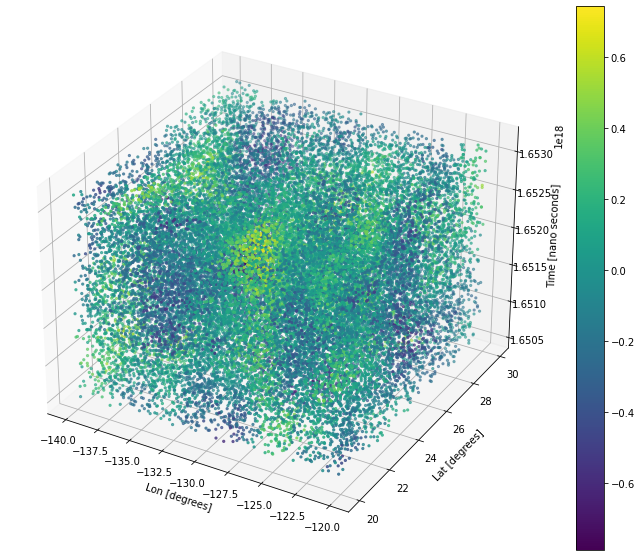

In [12]:
import os
import xarray as xr
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# noise_dir = "/home/jonas/Documents/Thesis/OceanPlatformControl/data/drifter_data/synthetic_error/area1"
# files = sorted(os.listdir(noise_dir))
# data = xr.load_dataset(os.path.join(noise_dir, files[0]))
data = xr.load_dataset("~/Downloads/plots/forecast_validation/vec_sample_noise.nc")
lon_len = len(data["lon"].values)
lat_len = len(data["lat"].values)
time_len = len(data["time"].values)
total_len = lon_len * lat_len * time_len

idx = np.random.choice(list(range(total_len)), size=30000)

lon = data["lon"].values.reshape(-1)
lat = data["lat"].values.reshape(-1)
time = data["time"].values.reshape(-1)

axes = np.array(list(itertools.product(lon, lat, time)))[idx]
lon = axes[:, 0]
lat = axes[:, 1]
time = axes[:, 2]
u_error = data["u_error"].values.reshape(-1)[idx]

data = pd.DataFrame({"lon": lon,
                     "lat": lat,
                     "time": time,
                     "u_error": u_error,
                     "v_error": u_error})

time_plot = np.array(time, dtype=np.int64)

fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(projection="3d")
plot = ax.scatter(lon, lat, time_plot, c=u_error, marker=".")
ax.set_xlabel("Lon [degrees]")
ax.set_ylabel("Lat [degrees]")
ax.set_zlabel("Time [nano seconds]")
plt.colorbar(plot, ax=ax)

In [14]:
from ocean_navigation_simulator.generative_error_model.variogram.Variogram import Variogram
from ocean_navigation_simulator.generative_error_model.variogram.VisualizeVariogram import VisualizeVariogram

print(data)
v = Variogram(data)
v.detrend()
bins, bins_count = v.build_variogram_gen((5, 1), num_workers=2, chunk_size=int(1e6), cross_buoy_pairs_only=False, is_3d=False)
vvis = VisualizeVariogram(None, variogram=v)

              lon        lat                time   u_error   v_error  \
0         -126.25  22.833333 2022-05-20 15:30:00  0.049991  0.049991   
1     -134.666667  25.416667 2022-04-25 03:30:00 -0.107702 -0.107702   
2         -123.75  27.166667 2022-04-29 09:30:00 -0.151071 -0.151071   
3         -135.75  20.083333 2022-05-19 08:30:00 -0.125989 -0.125989   
4     -128.333333  25.083333 2022-04-22 20:30:00  0.027889  0.027889   
...           ...        ...                 ...       ...       ...   
29995     -123.25  25.416667 2022-05-10 10:30:00  0.126035  0.126035   
29996 -133.416667  23.083333 2022-05-07 23:30:00 -0.338706 -0.338706   
29997 -136.416667      20.25 2022-05-12 21:30:00 -0.151548 -0.151548   
29998 -135.833333  28.166667 2022-04-26 08:30:00  0.098650  0.098650   
29999 -125.916667      25.75 2022-05-13 06:30:00 -0.261675 -0.261675   

        lat_bins  detrended_u_error  detrended_v_error  time_offset  
0      20.0,30.0           0.340970           0.340970          6

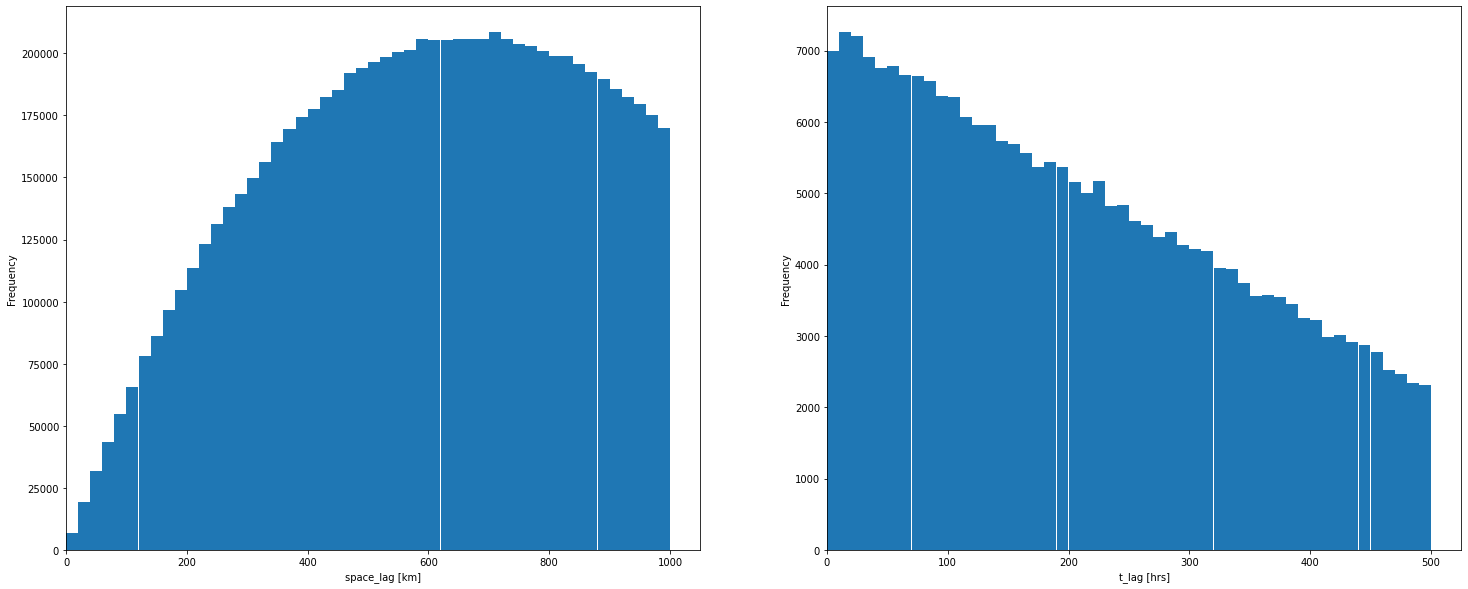

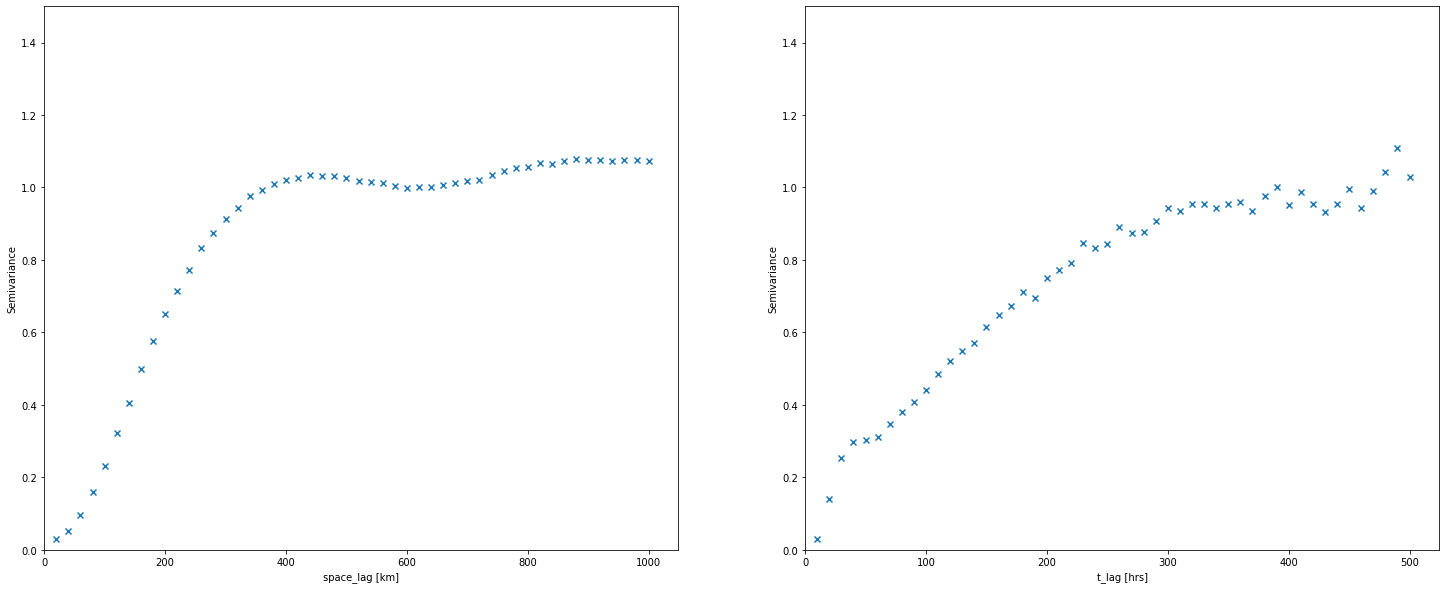

In [16]:
vvis.decrease_variogram_res((20, 10))
view_range = [1000, 500]
vvis.plot_histograms(view_range=view_range)
vvis.plot_variograms(view_range=view_range)